## Declarations

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import zipfile
import glob
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from tqdm import tqdm

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.12.0
Num GPUs Available:  1


### Constants

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
image_dir = "./resized_train"
#image_dir = "./colors"
caption_pred_file = "caption_prediction_train.csv"
#caption_pred_file = "caption_prediction.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"

In [4]:
feature_types = {'image': tf.float16, 'caption': tf.int64, 'raw caption': tf.string, 'image path': tf.string}
feature_shapes = {'image': (128, 128, 3), 'caption': (393, )}
base_features = ["image", "caption"]

In [5]:
batch_size = 32
epochs = 100

## Preprocessing

### File reading

In [6]:
def count_missing(archive, folder_prefix=""):
    missing = []
    for f in tqdm(archive.namelist()):
        if not os.path.isfile(folder_prefix + f):
            missing.append(f)
    print(f"\nMissing {len(missing)} files")
    return missing

def extract_files(archive, file_list=None, file_range=None, folder_prefix="", file_pre="", file_ext="", num_offset=0):
    if file_list:
        for f in tqdm(file_list):
            if f in archive.namelist():
                archive.extract(f, folder_prefix)
    elif file_range:
        for i in tqdm(range(*file_range)):
            f = file_pre + str(i).rjust(num_offset, "0") + file_ext
            if f in archive.namelist():
                archive.extract(f, folder_prefix)
    else:
        print("Specify list or range")

def copy_files(archive, destination, file_list=None, file_range=None, folder_prefix="", file_pre="", file_ext="", num_offset=0):
    if file_list:
        for f in tqdm(file_list):
            if f in archive.namelist():
                shutil.copy(folder_prefix + f, destination)
    elif file_range:
        for i in tqdm(range(*file_range)):
            f = file_pre + str(i).rjust(num_offset, "0") + file_ext
            if f in archive.namelist():
                shutil.copy(folder_prefix + f, destination)
    else:
        print("Specify list or range")

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Hackaton

Mounted at /gdrive
/gdrive/My Drive/Hackaton


In [ ]:
# Check for complete dataset
archive = zipfile.ZipFile('resized_train.zip')
missing = count_missing(archive)
if len(missing) > 0:
    print("Extracting missing files")
    extract_files(archive, file_list=missing, folder_prefix="temp/")
    copy_files(archive, "resized_train", file_list=missing, folder_prefix="temp/")

  0%|          | 0/83276 [00:00<?, ?it/s]

In [8]:
concepts = pd.read_csv(concept_file, sep='\t')
concept_list = concepts.set_index('concept')['concept_name'].to_dict()

captions = pd.read_csv(caption_pred_file, sep='\t')
captions = captions.set_index('ID')['caption'].to_dict()
captions = {id: "[SOS] " + caption + " [EOS]" for id, caption in captions.items()}

concepts = pd.read_csv(concept_det_file, sep='\t')
concepts = concepts.set_index('ID')['cuis'].to_dict()
concepts = {id: item_concepts.split(";") for id, item_concepts in concepts.items()}

In [9]:
# Define a list of characters to strip from input text
strip_chars = string.punctuation

# Remove "[" and "]" from the list of stripped characters
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    # TODO
    #return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
    return lowercase

In [10]:
result = ""
for i in captions.values():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
vocab_size = len(set(result.split()))
print("Vocab size:")
print(vocab_size)

longest = max(captions.values(), key=len)
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
sequence_length = len(longest)
print("Longest sequence:")
print(sequence_length)

concept_size = max([len(c) for _, c in concepts.items()])
print("Max number of concepts:")
print(concept_size)

Vocab size:
35491
Longest sequence:
393
Max number of concepts:
50


### Generating dataset

In [11]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3, dct_method="INTEGER_ACCURATE")

    # may need resizing
    #image = tf.image.resize(image, image_shape[:2])
    image = tf.cast(image, dtype=tf.float16)
    image = image / 255.0
    return image

def create_dataset(features, feature_types, feature_shapes, batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: features, {x: feature_types[x] for x in feature_types if x != "image"})
    
    dataset = dataset.map(lambda x: {
        f:x[f] if f != "image" else load_image(x["image path"])
        for f in feature_types.keys()
    })

    def setshape(x, feature_shapes):
        for (k, v) in feature_shapes.items():
            x[k].set_shape(v)
        return x

    dataset = dataset.map(lambda x: setshape(x, feature_shapes))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


def load_features(image_folder, captions_file):
    features = []

    # Check that CSV file has no extra rows/columns
    csv_dataset = tf.data.experimental.CsvDataset(
        captions_file,
        field_delim='\t',
        record_defaults=[tf.string, tf.string],
        header=True,
        select_cols=[0, 1]
    )

    # Extract features from dataset
    print("Extracting features from CSV file(s)")
    for filename, caption in tqdm(csv_dataset):
        features.append({
            'raw caption': caption,
            'image path': image_dir + "/" + filename + ".jpg",
            # Eventually introduce concepts
        })

    # Preprocess concepts
    #if image_concepts:
    #    classes = image_concepts[filename]
    #    classes = np.pad(classes, (0, concept_size - len(classes)), constant_values = None)
    #    concepts.append(classes)

    return features

def vectorize_field(features, vectorizer, field_name, new_field_name):
    print(f"Vectorizing {field_name}")
    if features:
        return [
            dict(item, **{new_field_name:vectorizer(item[field_name])}) 
            for item in tqdm(features)
        ]
    return None

def split(x, test_size=0.2, val_size=0.0, seed=0):
    if val_size + test_size >= 1:
        return None
    x_train, x_test = train_test_split(
        x, test_size=test_size + val_size, random_state=seed
    )
    x_val = None
    if val_size > 0:
        x_test, x_val = train_test_split(
            x_test,
            test_size=val_size / (test_size + val_size),
            random_state=seed,
        )
    return x_train, x_val, x_test

def base_dataset(dataset, base_features):
    return dataset.map(lambda x: {f:x[f] for f in base_features})

def visualize_first_of_dataset_batch(dataset_batch, nums=5):
    for c in range(0, nums):
        i = tf.cast(dataset_batch["image"][c], dtype=tf.float32)
        t = dataset_batch["raw caption"][c]
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, c + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])

In [12]:
# Load dataset features from csv files and split them
features = load_features(image_dir, caption_pred_file)
feat_train, feat_val, feat_test = split(features, test_size=0.2, val_size=0.0, seed=seed)

Extracting features from CSV file(s)


83275it [00:57, 1446.00it/s]


In [13]:
# Train a vectorizer on the raw captions of the train dataset
text_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
)

train_captions = [f["raw caption"].numpy() for f in feat_train]
text_vectorization.adapt(train_captions)

In [15]:
# Apply vectorization to the rest of the dataset
feat_train = vectorize_field(feat_train, text_vectorization, "raw caption", "caption")
train_ds_size = len(feat_train)
feat_val = vectorize_field(feat_val, text_vectorization, "raw caption", "caption")
feat_test = vectorize_field(feat_test, text_vectorization, "raw caption", "caption")

# Generate batched prefetched datasets
train_dataset = create_dataset(feat_train, feature_types, feature_shapes, batch_size)
val_dataset = create_dataset(feat_val, feature_types, feature_shapes, batch_size)
test_dataset = create_dataset(feat_test, feature_types, feature_shapes, batch_size)

Vectorizing raw caption
Vectorizing raw caption


100%|██████████| 16655/16655 [02:54<00:00, 95.29it/s] 


In [ ]:
# visualize_first_of_dataset_batch(next(iter(ds_train)))

## Network

### Network blocks

In [16]:
def CNN_embedding(input_shape, latent_dim, embed_dim, seed, supernet=None, preprocessing=None):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')
    
    if not supernet:
        x = tfkl.ZeroPadding2D((2,2))(input_layer)

        x = tfkl.Conv2D(64, 3, padding='same', strides=2)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

        x = tfkl.Conv2D(128, 3, padding='same', strides=2)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

        x = tfkl.Conv2D(256, 3, padding='same', strides=2)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

    else:
        x = preprocessing(input_layer)
        x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)
    x = tfkl.Dense(latent_dim, activation='relu')(x)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)

    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the discriminator
    return cnn_encoder

In [17]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

In [18]:
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        
    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [19]:
def text_embedding(sequence_lenght, vocab_size, num_heads, embed_dim, latent_dim):
    input_layer = tfk.Input(shape=(None,), dtype="int64", name="text_inputs")
    x = TokenAndPositionEmbedding(sequence_lenght, vocab_size, embed_dim)(input_layer)
    x = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
    
    text_encoder = tfk.Model(input_layer, x)
    
    return text_encoder

In [20]:
class CLIP(tfk.Model):
    def __init__(self, image_encoder, text_encoder, temp=0.07, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temp = temp
        self.loss_tracker = tfk.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        image_emb = self.image_encoder(features["image"], training=training)
        text_emb = self.text_encoder(features["caption"], training=training)
        return image_emb, text_emb

    def CLIP_loss(self, image_emb, text_emb):
        norm_image_emb = tf.math.l2_normalize(image_emb, axis=1)
        norm_text_emb = tf.math.l2_normalize(text_emb, axis=1)

        logits = tf.linalg.matmul(norm_image_emb, norm_text_emb, transpose_b=True) * tf.math.exp(self.temp)

        n = tf.shape(logits)[0]
        labels = tf.range(n)

        loss_img = tfk.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_txt = tfk.losses.sparse_categorical_crossentropy(labels, kb.transpose(logits), from_logits=True)

        return (loss_img + loss_txt) / tf.constant(2.0)

        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        #images_similarity = tf.matmul(
        #    image_embeddings, image_embeddings, transpose_b=True
        #)
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        #captions_similarity = tf.matmul(
        #    caption_embeddings, caption_embeddings, transpose_b=True
        #)
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        #targets = keras.activations.softmax(
        #    (captions_similarity + images_similarity) / (2 * self.temperature)
        #)
        # Compute the loss for the images using crossentropy
        #images_loss = keras.losses.categorical_crossentropy(
        #    y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        #)
        # Compute the loss for the captions using crossentropy
        #captions_loss = keras.losses.categorical_crossentropy(
        #    y_true=targets, y_pred=logits, from_logits=True
        #)
        # Return the mean of the loss over the batch.
        #return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            image_embeddings, caption_embeddings = self(features, training=True)
            loss = self.CLIP_loss(caption_embeddings, image_embeddings)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        image_embeddings, caption_embeddings = self(features, training=False)
        loss = self.CLIP_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


### Building network

In [21]:
def build_clip(img_input_shape=(128, 128, 3),
               txt_input_shape=(393, ), 
               latent_dim=1024, 
               embed_dim=128, 
               seq_lenght=393, 
               vocab_size=35491, 
               num_heads=4,
               temp=0.07,
               supernet=None,
               preprocessing=None):
    
    img_input = tfk.Input(shape=img_input_shape)
    txt_input = tfk.Input(shape=txt_input_shape)
    
    img_embed = CNN_embedding(img_input_shape, latent_dim, embed_dim, seed=42, supernet=supernet, preprocessing=preprocessing)(img_input)
    image_encoder = tfk.Model(img_input, img_embed, name = "image_encoder")

    txt_embed = text_embedding(seq_lenght, vocab_size, num_heads, embed_dim, latent_dim)(txt_input)
    txt_embed = tfkl.GlobalAveragePooling1D()(txt_embed)
    txt_embed = tfkl.Dense(embed_dim, name="text_encoder")(txt_embed)
    text_encoder = tfk.Model(txt_input, txt_embed, name = "text_encoder")

    clip = CLIP(image_encoder, text_encoder, temp)
    clip.compile(optimizer = tf.optimizers.Adam())
    return image_encoder, text_encoder, clip

In [22]:
# Build clip with a CNN from scratch
image_encoder, text_encoder, clip = build_clip()

# Build clip with a frozen convnext
#image_encoder, text_encoder, clip = build_clip(
#    supernet=tfk.applications.ConvNeXtTiny(weights='imagenet', include_top=False), 
#    preprocessing=tfk.applications.convnext.preprocess_input
#    )

#clip.summary()

## Training

### CLIP pre-training

In [24]:
# Create a learning rate scheduler callback.
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.2, patience = 3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)

base_ds_train = base_dataset(train_dataset, base_features)
base_ds_val = base_dataset(test_dataset, base_features)

history = clip.fit(
    base_ds_train,
    steps_per_epoch=train_ds_size/batch_size,
    epochs = epochs,
    validation_data = base_ds_val,
    callbacks = [reduce_lr, early_stopping],
)

Epoch 1/100
 153/2081 [=>............................] - ETA: 6:35:41 - loss: 3.4657

KeyboardInterrupt: ignored

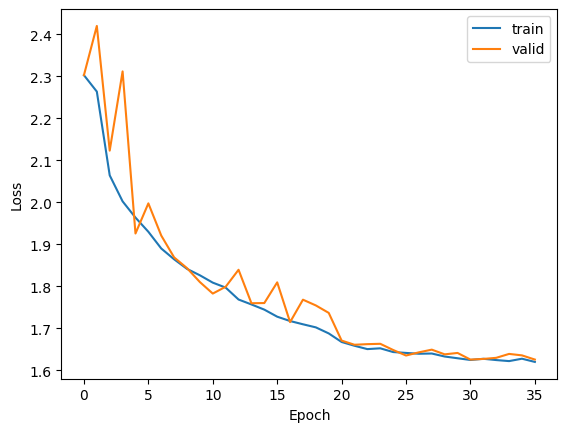

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
clip.save("keras_clip_model")

### Encoder/Decoder training

In [ ]:
def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return image_array

In [ ]:
def find_matches(image_embeddings, queries, k=5, normalize=True):
    queries_vec = [text_vectorization(query) for query in queries]
    queries_vec = tf.data.Dataset.from_tensor_slices(queries_vec).batch(batch_size)
    # Get the embedding for the query.
    query_embedding = text_encoder.predict(queries_vec)
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[train_image_paths[idx] for idx in indices] for indices in results]

In [ ]:
train_data = [p for p in ds_train]
val_data = [p for p in ds_val]
test_data = [p for p in ds_test]

train_image_paths = [e["image path"] for e in train_data]
test_image_paths = [e["image path"] for e in test_data]

# TODO: this part only generates embeddings on the training dataset for now
# TODO: this code re-reads the images
image_embeddings = image_encoder.predict(
    tf.data.Dataset.from_tensor_slices(train_image_paths).map(read_image).batch(batch_size),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")


In [ ]:
query = "active pheochromocytoma"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

print("Top matches for query: \"" + query + "\"")

plt.figure(figsize=(18, 18))
for i in range(9):
    path = matches[i].numpy().decode('UTF-8')
    caption = next(x["raw caption"] for x in train_data if x["image path"].numpy().decode('UTF-8') == path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(path))
    plt.axis("off")
    print(caption)


## Evaluation

In [ ]:
# TODO: might not work, needs revising

def compute_top_k_accuracy(image_paths, k=5):
    hits = 0
    num_batches = int(np.ceil(len(image_paths) / batch_size))
    for idx in range(num_batches):
        start_idx = idx * batch_size
        end_idx = start_idx + batch_size
        current_image_paths = image_paths[start_idx:end_idx]
        queries = [ captions[os.path.splitext(image_path.numpy().decode('UTF-8').split(os.sep)[-1])[0]] for image_path in current_image_paths ]
        result = find_matches(image_embeddings, queries, k)
        hits += sum(
            [
                image_path in matches for (image_path, matches) in list(zip(current_image_paths, result))
            ]
        )

    return hits / len(image_paths)

n = 1920

print(test_image_paths)

print("Scoring training data...")
train_accuracy = compute_top_k_accuracy(random.sample(train_image_paths, n))
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(random.sample(test_image_paths, n))
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")
